../../original_images/psvrt.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/as186233/anaconda2/envs/py36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/as186233/anaconda2/envs/py36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/as186233/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/as186233/anaconda2/envs/py36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/as186233/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/kernelapp.py

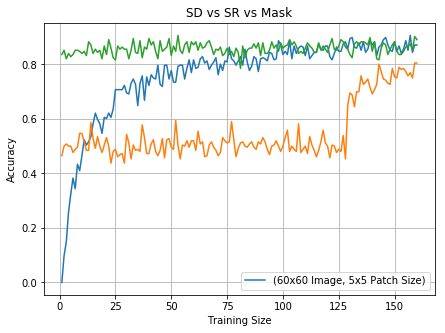

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import cv2, os, math, time, sys
from datetime import timedelta
from sklearn.utils import shuffle
sys.path.append('../../original_images')
from gen_data_batch import generate_batch

In [27]:
###Configuration
"""
Data Configurations/Paths
"""
img_dir_patch="./SD/predicted_patches"
img_dir_orig = "../../original_images/SD"

modelsd_test = 'SD/modelsd_test.ckpt'
modelsr_test = 'SD/modelsr_test.ckpt'
modelleft = 'SD/modelleft.ckpt'
modelright = 'SD/modelright.ckpt'
model_mask_sd = 'SD/model_mask_sd.ckpt'

# img_type = "original"
img_type = "patch"

##
# Convolutional Layer 1.
filter_size1 = 4          # Convolution filters are 4 x 4 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 2          # Convolution filters are 2 x 2 pixels.
num_filters2 = 32         # There are 32 of these filters.

# Convolutional Layer 3.
filter_size3 = 2          # Convolution filters are 2 x 2 pixels.
num_filters3 = 64         # There are 64 of these filters.

# Convolutional Layer 4.
filter_size4 = 2          # Convolution filters are 2 x 2 pixels.
num_filters4 = 128         # There are 128 of these filters.

# Fully-connected layer.
fc_size = 256             # Number of neurons in fully-connected layer.

# Number of colour channels for the images: 3 channel for RGB.
num_channels = 3

# Tuple with height and width of images used to reshape arrays.
img_shape = (60, 60, num_channels)
item_size = (5,5)
mask_sd_input = (10,5, num_channels)
# Number of classes, one class for same and one for different image
num_classes = 2
nitems = 2

In [ ]:
train_batch_size = 64
train_data, mask_labels, left_mask, right_mask, labels = generate_batch(train_batch_size, img_shape, item_size, nitems)
print(train_data.shape)
print(mask_labels.shape)
print(left_mask.shape)
print(right_mask.shape)
see_output(np.reshape(train_data, [64, 60,60,3])[:1, :,:,:])
see_output_grey(mask_labels[:1, :,:])
see_output_grey(left_mask[:1, :, :])
see_output_grey(right_mask[:1, :, :])

In [3]:
def load_data(img_dir, img_type="patch"):
        list_of_imgs = []
        list_same_diff = []
        for img_no in os.listdir(img_dir):
            img_no_path = os.path.join(img_dir, img_no)
            for img_label in os.listdir(img_no_path):
                    
                list_same_diff.append(int(img_label))
                img_lbl_path = os.path.join(img_no_path, img_label)
#                 print(img_lbl_path)
                if img_type == "original":
                    img_lbl_path = img_lbl_path + "/img/"
                    
                if img_type == "patch":
                    for img in os.listdir(img_lbl_path):
#                         if img == "labels":
                        img_path = os.path.join(img_lbl_path, img)
#                             img_path = img_path + "/merged_patch.png"
                        list_of_imgs.append(img_path)
                else:    
                    for img in os.listdir(img_lbl_path):
                        img_path = os.path.join(img_lbl_path, img)
                        list_of_imgs.append(img_path)
#         print(list_of_imgs)
        data_imgs = np.array(list_of_imgs)
        data_same_diff = np.array(list_same_diff)

        return data_imgs, data_same_diff
    
def get_batch_images(data, same_diff, type_img = "patch"):
        list_of_imgs = []
        list_of_same_diff = []
        for img, img_type in zip(data, same_diff):
            orig_img = cv2.imread(img)
            #only first image as a label
            if orig_img is None:
                    print ("Unable to read image{}".format(img))
                    continue
            
            if type_img == "original":
                flattened_img = orig_img.flatten()
                list_of_imgs.append(np.asarray(flattened_img, dtype=np.float32))
                
                if img_type == 1: #0 is same and 1 is different
                    list_of_same_diff.append([0,1])
                else:
                    list_of_same_diff.append([1,0])
            else:            
                if orig_img.shape == (4, 2, 3):
                    flattened_img = orig_img.flatten()
                    list_of_imgs.append(np.asarray(flattened_img, dtype=np.float32))

                    if img_type == 1: #0 is same and 1 is different
                        list_of_same_diff.append([0,1])
                    else:
                        list_of_same_diff.append([1,0])
        
        data_imgs = np.array(list_of_imgs)
        data_img_type = np.array(list_of_same_diff)
        
        return data_imgs, data_img_type

def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

def patch_next_batch(num, data, lft_lbls, rght_lbls, img_tlbl, img_key):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data[0]))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_orig = data[0, :]
    data_pred = data[1, :]
    data_orig_shuffle = [data[0, i] for i in idx]
    data_pred_shuffle = [data[1, i] for i in idx]
    lft_labels = [lft_lbls[ i] for i in idx]
    rght_labels = [rght_lbls[ i] for i in idx]
    img_tlbl = [img_tlbl[ i] for i in idx]
    img_key = [img_key[ i] for i in idx]

    return np.asarray(data_orig_shuffle), np.asarray(data_pred_shuffle), np.asarray(lft_labels), np.asarray(rght_labels), np.asarray(img_tlbl), np.asarray(img_key)

In [4]:
def new_weights(shape, layer_name):
    initializer = tf.contrib.layers.xavier_initializer()
    return tf.Variable(initializer(shape), name=layer_name+'_W')

def new_bias(length, layer_name):
    return tf.Variable(tf.constant(0.05, shape=[length]), name=layer_name+'_b')

def new_conv_layer(input,
                   num_input_channels,
                   filter_size,
                   num_filters,
                   name_scope,
                   layer_name='',
                   use_pooling=True):

    with tf.name_scope(name_scope):
        shape = [filter_size, filter_size, num_input_channels, num_filters]
        weights = new_weights(shape, layer_name)
        biases = new_bias(num_filters, layer_name)

        layer = tf.add(tf.nn.conv2d(input=input, filter=weights, strides=[1,1,1,1], padding='SAME'), biases, name=layer_name)

        if use_pooling:
            layer = tf.nn.max_pool(value=layer,
                                   ksize=[1, 3, 3, 1],
                                   strides=[1, 2, 2, 1],
                                   padding='SAME', name=layer_name+'_max')
        layer = tf.nn.relu(layer, name=layer_name+'_activation')

    return layer, weights

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features

def new_fc_layer(input,
                num_inputs,
                num_outputs,
                name_scope,
                layer_name='',
                use_relu=True):
    
    with tf.name_scope(name_scope):
        weights = new_weights([num_inputs, num_outputs], layer_name)
        biases = new_bias(num_outputs, layer_name)

        layer = tf.add(tf.matmul(input, weights),biases,name=layer_name)
    #     layer = tf.matmul(input, weights) + biases

        if use_relu:
            layer = tf.nn.relu(layer, layer_name+'_activation')
    
    return layer

def normalise(tensor):
    return tf.div(
   tf.subtract(
      tensor, 
      tf.reduce_min(tensor)
   ), 
   tf.subtract(
      tf.reduce_max(tensor), 
      tf.reduce_min(tensor)
   )
)

def normalized(arr):
    return (arr - np.min(arr))/(np.max(arr) - np.min(arr))

In [5]:
# mask_graph layer configurations
m_filter_size0 = 16          # Convolution filters are 4 x 4 pixels.
m_num_filters0 = 16         # There are 16 of these filters.

m_filter_size1 = 8          # Convolution filters are 4 x 4 pixels.
m_num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
m_filter_size2 = 8          # Convolution filters are 2 x 2 pixels.
m_num_filters2 = 16         # There are 32 of these filters.

m_filter_size3 = 8          # Convolution filters are 2 x 2 pixels.
m_num_filters3 = 4         # There are 32 of these filters.

# Convolutional Layer 3.
m_filter_size4 = 4          # Convolution filters are 2 x 2 pixels.
m_num_filters4 = 32         # There are 64 of these filters.

m_filter_size5 = 2          # Convolution filters are 2 x 2 pixels.
m_num_filters5 = 16         # There are 64 of these filters.


# Fully-connected layer.
m_fc_size = 2000             # Number of neurons in fully-connected layer.

mask_graph = tf.Graph()
with mask_graph.as_default():
    m_x = tf.placeholder(tf.float32, shape=[None, img_shape[0] * img_shape[1] * img_shape[2]], name='m_x')
    m_x_image = tf.reshape(m_x, [-1, img_shape[0], img_shape[1], num_channels])
    m_y_true = tf.placeholder(tf.float32, shape=[None, img_shape[0] * img_shape[1]], name='m_y_true')
    m_y_true_cls = tf.placeholder(tf.float32, shape=[None, img_shape[0] * img_shape[1]], name='m_y_true_cls')    
    
    layer0_conv0, weights_conv0 = new_conv_layer(input=m_x_image,
                                                num_input_channels=num_channels,
                                                filter_size=m_filter_size0,
                                                num_filters=m_num_filters0,
                                                 name_scope = 'mask',
                                                 layer_name = 'conv1',
                                                use_pooling=True)

    layer1_conv1, weights_conv1 = new_conv_layer(input=layer0_conv0,
                                                num_input_channels=m_num_filters0,
                                                filter_size=m_filter_size1,
                                                num_filters=m_num_filters1,
                                                 name_scope = 'mask',
                                                 layer_name = 'conv2',
                                                use_pooling=True)


    layer2_conv2, weights_conv2 =  new_conv_layer(input=layer1_conv1,
                                               num_input_channels=m_num_filters1,
                                               filter_size=m_filter_size2,
                                               num_filters=m_num_filters2,
                                                 name_scope = 'mask',
                                                 layer_name = 'conv3',
                                               use_pooling=True)

    layer3_conv3, weights_conv3 =  new_conv_layer(input=layer2_conv2,
                                               num_input_channels=m_num_filters2,
                                               filter_size=m_filter_size3,
                                               num_filters=m_num_filters3,
                                                 name_scope = 'mask',
                                                 layer_name = 'conv4',
                                               use_pooling=True)

    layer4_conv4, weights_conv4 =  new_conv_layer(input=layer3_conv3,
                                               num_input_channels=m_num_filters3,
                                               filter_size=m_filter_size4,
                                               num_filters=m_num_filters4,
                                                 name_scope = 'mask',
                                                 layer_name = 'conv5',
                                               use_pooling=True)


    layer5_conv5, weights_conv5 =  new_conv_layer(input=layer4_conv4,
                                               num_input_channels=m_num_filters4,
                                               filter_size=m_filter_size5,
                                               num_filters=m_num_filters5,
                                                 name_scope = 'mask',
                                                 layer_name = 'conv6',
                                               use_pooling=True)

    layer_flat, num_features = flatten_layer(layer5_conv5)

    layer_fc1 = new_fc_layer(input=layer_flat,
                             num_inputs=num_features,
                             num_outputs=m_fc_size,
                             name_scope = 'mask',
                             layer_name = 'fc1',
                             use_relu=True)

    layer_fc2 = new_fc_layer(input=layer_fc1,
                             num_inputs=m_fc_size,
                             num_outputs=m_fc_size,
                             name_scope = 'mask',
                             layer_name = 'fc2',
                             use_relu=False)

    layer_fc3 = new_fc_layer(input=layer_fc2,
                             num_inputs=m_fc_size,
                             num_outputs=m_fc_size,
                             name_scope = 'mask',
                             layer_name = 'fc3',
                             use_relu=False)

    layer_fc4 = new_fc_layer(input=layer_fc3,
                             num_inputs=m_fc_size,
                             num_outputs=img_shape[0] * img_shape[1],
                             name_scope = 'mask',
                             layer_name = 'fc4',
                             use_relu=False)

    # drop_out = tf.nn.dropout(layer_fc4, 0.5, name="drop_out")
#     print(layer_fc4)
    # y_pred = tf.nn.softmax(layer_fc4, name="softmax_output")
    y_pred = layer_fc4
    cost = tf.reduce_mean(tf.square(m_y_true - y_pred))
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

    # ## some more performance measures
    correct_prediction = tf.equal(y_pred, m_y_true)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    

In [6]:
sd_graph = tf.Graph()
with sd_graph.as_default():

    x = tf.placeholder(tf.float32, shape=[None, img_shape[0]*img_shape[1]*num_channels], name='x')
    x_image = tf.reshape(x, [-1, img_shape[0], img_shape[1], num_channels])
    s_y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
    s_y_true_cls = tf.argmax(s_y_true, axis=1)        

    layer1_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                                num_input_channels=num_channels,
                                                filter_size=filter_size1,
                                                num_filters=num_filters1,
                                                 name_scope = 'sd_graph',
                                                 layer_name = 'conv1',
                                                use_pooling=True)

    layer2_conv2, weights_conv2 = new_conv_layer(input=layer1_conv1,
                                                num_input_channels=num_filters1,
                                                filter_size=filter_size2,
                                                num_filters=num_filters2,
                                                 name_scope = 'sd_graph',
                                                 layer_name = 'conv2',
                                                use_pooling=True)


    layer3_conv3, weights_conv3 =  new_conv_layer(input=layer2_conv2,
                                               num_input_channels=num_filters2,
                                               filter_size=filter_size3,
                                               num_filters=num_filters3,
                                                 name_scope = 'sd_graph',
                                                 layer_name = 'conv3',
                                               use_pooling=True)

    layer4_conv4, weights_conv4 =  new_conv_layer(input=layer3_conv3,
                                               num_input_channels=num_filters3,
                                               filter_size=filter_size4,
                                               num_filters=num_filters4,
                                                 name_scope = 'sd_graph',
                                                 layer_name = 'conv4',
                                               use_pooling=True)

    layer_flat, num_features = flatten_layer(layer4_conv4)       

    layer_fc1 = new_fc_layer(input=layer_flat,
                     num_inputs=num_features,
                     num_outputs=fc_size,
                     name_scope = 'sd_graph',
                     layer_name = 'fc1',
                     use_relu=True)

    layer_fc2 = new_fc_layer(input=layer_fc1,
                             num_inputs=fc_size,
                             num_outputs=fc_size,
                             name_scope = 'sd_graph',
                             layer_name = 'fc2',
                             use_relu=False)

    layer_fc3 = new_fc_layer(input=layer_fc2,
                             num_inputs=fc_size,
                             num_outputs=fc_size,
                             name_scope = 'sd_graph',
                             layer_name = 'fc3',
                             use_relu=False)

    layer_fc4 = new_fc_layer(input=layer_fc3,
                             num_inputs=fc_size,
                             num_outputs=num_classes,
                             name_scope = 'sd_graph',
                             layer_name = 'fc4',
                             use_relu=False)

    s_drop_out = tf.nn.dropout(layer_fc4, 0.5)
    s_y_pred = tf.nn.softmax(s_drop_out)
    s_y_pred_cls = tf.argmax(s_y_pred, axis=1)        
    s_cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=s_drop_out, labels=s_y_true)
    s_cost = tf.reduce_mean(s_cross_entropy)
    s_optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(s_cost)
    s_correct_prediction = tf.equal(s_y_pred_cls, s_y_true_cls)
    s_accuracy = tf.reduce_mean(tf.cast(s_correct_prediction, tf.float32))        

    #         y_pred = layer_fc4        
    #         cost = tf.reduce_mean(tf.square(y_true - y_pred))
    #         optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

    #         # ## some more performance measures
    #         correct_prediction = tf.equal(y_pred, y_true)
    #         accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [7]:
mask_sd_graph = tf.Graph()
with mask_sd_graph.as_default():
    mask_sd_x = tf.placeholder(tf.float32, shape=[None, mask_sd_input[0]*mask_sd_input[1]*num_channels], name='mask_sd_x')
    mask_sd_x_image = tf.reshape(mask_sd_x, [-1, mask_sd_input[0], mask_sd_input[1], num_channels])

    mask_sd_y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='mask_sd_y_true')
    mask_sd_y_true_cls = tf.argmax(mask_sd_y_true, axis=1)        

    layer1_conv1, weights_conv1 = new_conv_layer(input=mask_sd_x_image,
                                                num_input_channels=num_channels,
                                                filter_size=filter_size1,
                                                num_filters=num_filters1,
                                                 name_scope = 'mask_sd_graph',
                                                 layer_name = 'conv1',
                                                use_pooling=True)

    layer2_conv2, weights_conv2 = new_conv_layer(input=layer1_conv1,
                                                num_input_channels=num_filters1,
                                                filter_size=filter_size2,
                                                num_filters=num_filters2,
                                                 name_scope = 'mask_sd_graph',
                                                 layer_name = 'conv2',
                                                use_pooling=True)


    layer3_conv3, weights_conv3 =  new_conv_layer(input=layer2_conv2,
                                               num_input_channels=num_filters2,
                                               filter_size=filter_size3,
                                               num_filters=num_filters3,
                                                 name_scope = 'mask_sd_graph',
                                                 layer_name = 'conv3',
                                               use_pooling=True)

    layer4_conv4, weights_conv4 =  new_conv_layer(input=layer3_conv3,
                                               num_input_channels=num_filters3,
                                               filter_size=filter_size4,
                                               num_filters=num_filters4,
                                                 name_scope = 'mask_sd_graph',
                                                 layer_name = 'conv4',
                                               use_pooling=True)

    layer_flat, num_features = flatten_layer(layer4_conv4)       

    layer_fc1 = new_fc_layer(input=layer_flat,
                     num_inputs=num_features,
                     num_outputs=fc_size,
                     name_scope = 'mask_sd_graph',
                     layer_name = 'fc1',
                     use_relu=True)

    layer_fc2 = new_fc_layer(input=layer_fc1,
                             num_inputs=fc_size,
                             num_outputs=fc_size,
                             name_scope = 'mask_sd_graph',
                             layer_name = 'fc2',
                             use_relu=False)

    layer_fc3 = new_fc_layer(input=layer_fc2,
                             num_inputs=fc_size,
                             num_outputs=fc_size,
                             name_scope = 'mask_sd_graph',
                             layer_name = 'fc3',
                             use_relu=False)

    layer_fc4 = new_fc_layer(input=layer_fc3,
                             num_inputs=fc_size,
                             num_outputs=num_classes,
                             name_scope = 'mask_sd_graph',
                             layer_name = 'fc4',
                             use_relu=False)

    mask_sd_drop_out = tf.nn.dropout(layer_fc4, 0.5)
    mask_sd_y_pred = tf.nn.softmax(mask_sd_drop_out)
    mask_sd_y_pred_cls = tf.argmax(mask_sd_y_pred, axis=1)        
    mask_sd_cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=mask_sd_drop_out, labels=mask_sd_y_true)
    mask_sd_cost = tf.reduce_mean(mask_sd_cross_entropy)
    mask_sd_optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(mask_sd_cost)
    mask_sd_correct_prediction = tf.equal(mask_sd_y_pred_cls, mask_sd_y_true_cls)
    mask_sd_accuracy = tf.reduce_mean(tf.cast(mask_sd_correct_prediction, tf.float32))        

In [13]:
def get_coords(imgs, top):

    # Input data
    input = tf.placeholder(tf.float32, [None])
    orig_input = tf.placeholder(tf.float32, [None])
    # Submatrix dimension
    dims = tf.placeholder(tf.int32, [None])
    # Number of top submatrices to find
    k = tf.placeholder(tf.int32, [])

    my_inp = tf.reshape(input, [-1, img_shape[0],img_shape[1]])
    input_shape = tf.shape(my_inp)
    rows, cols = input_shape[1], input_shape[2]
    d_rows, d_cols = dims[0], dims[1]
    subm_rows, subm_cols = rows - d_rows + 1, cols - d_cols + 1

    # # Index grids
    ii, jj = tf.meshgrid(tf.range(subm_rows), tf.range(subm_cols), indexing='ij')
    d_ii, d_jj = tf.meshgrid(tf.range(d_rows), tf.range(d_cols), indexing='ij')
    # # # Add indices
    subm_ii = ii[:, :, tf.newaxis, tf.newaxis] + d_ii
    subm_jj = jj[:, :, tf.newaxis, tf.newaxis] + d_jj


    subm_st = tf.stack([subm_ii, subm_jj], axis=-1)
    # # Make submatrices tensor
    subm = tf.gather_nd(my_inp[0,:,:], tf.stack([subm_ii, subm_jj], axis=-1))
    # # Add submatrices
    subm_sum = tf.reduce_sum(subm, axis=(2, 3))
    # # Use TopK to find top submatrices
    _, top_idx = tf.nn.top_k(tf.reshape(subm_sum, [-1]), tf.minimum(k, tf.size(subm_sum)))
    # # # Get row and column
    top_row = top_idx // subm_cols
    top_col = top_idx % subm_cols
    result = tf.stack([top_row, top_col], axis=-1)
    
    with tf.Session() as sess1:
        lst_cds = []
        for img in imgs:
            res = sess1.run(result, feed_dict={input: img, orig_input:img,  dims: item_size, k: top})
            lst_cds.append(np.squeeze(res))

#         print(lst_cds)
    return np.array(lst_cds)
    # orig_img_x = cv2.imread("../../original_images/SD/15970/0/img/img.png")
#     orig_inp = tf.reshape(orig_input, [1, 10, 10, 3])
#     patches = tf.squeeze(tf.map_fn(lambda x: tf.cast(orig_inp[:, x[0]:x[0] + patch_size[0], x[1]:x[1] + patch_size[1], :], dtype=tf.float32), result, dtype=tf.float32))
#     patch_shape = tf.shape(patches)
#     reshaped_patches = tf.reshape(patches, [-1, patch_shape[0] * patch_shape[1], patch_shape[2], patch_shape[3]])

def extract_patch(locs, orig_batch):
    orig_batch = np.reshape(orig_batch, [-1,img_shape[0],img_shape[1],img_shape[2]])
#     print(orig_batch)
#     print(locs)
#     return np.array([loc for loc in locs])
    return np.array([orig_batch[idx:idx+1, loc[0]:loc[0]+item_size[0], loc[1]:loc[1]+item_size[1], :] for idx, loc in enumerate(locs)])



In [40]:
def train_mask(save_model, restore_model, restore_name, saver, session, end_batch, train_data, train_label):
    feed_dict_train = {m_x: train_data,
               m_y_true: train_label}

    session.run(optimizer, feed_dict=feed_dict_train)

    acc,co = session.run([accuracy, cost], feed_dict=feed_dict_train)            
    msg = "Optimization Iteration: {0:>6}, Mask Training Accuracy: {1:>6.1%}, Loss: {2:>.4f}"
    print(msg.format(end_batch + 1, acc, co))
    
    #once the training is done, run a test and return the patch
    
    

def train_mask_sd(save_model, restore_model, restore_name, saver, session, end_batch, train_data, train_label):
    feed_dict_train = {mask_sd_x: train_data,
               mask_sd_y_true: train_label}

    session.run(mask_sd_optimizer, feed_dict=feed_dict_train)

    acc,co = session.run([mask_sd_accuracy, mask_sd_cost], feed_dict=feed_dict_train)            
    msg = "Optimization Iteration: {0:>6}, Masked SD Training Accuracy: {1:>6.1%}, Loss: {2:>.4f}"
    print(msg.format(end_batch + 1, acc, co))


def train_sd(save_model, restore_model, restore_name, saver, session, end_batch, train_data, train_label):
    feed_dict_train = {x: train_data,
               s_y_true: train_label}

    session.run(s_optimizer, feed_dict=feed_dict_train)

    acc,co = session.run([s_accuracy, s_cost], feed_dict=feed_dict_train)            
    msg = "Optimization Iteration: {0:>6}, SD/SR Training Accuracy: {1:>6.1%}, Loss: {2:>.4f}"
    print(msg.format(end_batch + 1, acc, co))
                        
def restore_see_layer(orig, input_name, model_name=None, var_name=None):
    with tf.Session('', tf.Graph()) as s:
        with s.graph.as_default():
            if ((model_name != None) and var_name != None):
                saver = tf.train.import_meta_graph(model_name+".meta")
                saver.restore(s, model_name)
                fd = {input_name +':0': orig}
#                 print(fd.shape)
                var_name=var_name+":0"
                
                result = 0
                result = s.run(var_name, feed_dict=fd)
    return result  

def restore_see_layer_session(session, orig, input_name, var_name=None):
    result = 0
    with session.graph.as_default():
        fd = {input_name +':0': orig}
        var_name=var_name+":0"
        result = session.run(var_name, feed_dict=fd)
            
    return result  
    
def prepare_train_mask_sd(left_sess, right_sess, train_data, left_mask, right_mask):   
    
    cor_prd_imgs = 0

    lft_preds = restore_see_layer_session(left_sess, orig=train_data, input_name = 'm_x', var_name='mask_9/fc4')
    rght_preds = restore_see_layer_session(right_sess, orig=train_data, input_name = 'm_x', var_name='mask_9/fc4')

#     print(lft_preds)
#     print(rght_preds)
    
    lft_lbl_cds = get_coords(left_mask, 1)
    rght_lbl_cds = get_coords(right_mask, 1)
    lft_pred_cds = get_coords(lft_preds, 1)
    rght_pred_cds = get_coords(rght_preds, 1)
    
#     print(lft_lbl_cds)
#     print("******left predicted")
#     print(lft_pred_cds)
#     print("******")
#     print(rght_lbl_cds)
#     print("******right predicted")
#     print(rght_pred_cds)    
    
    left_patch = extract_patch(lft_pred_cds, train_data)
    right_patch = extract_patch(rght_pred_cds, train_data)
        
    print(left_patch.shape, right_patch.shape)
    
    cor_prd_imgs = np.sum([True for llc, lpc, rlc, rpc  in zip(lft_lbl_cds, lft_pred_cds, rght_lbl_cds, rght_pred_cds) if np.array_equal(llc, lpc) and np.array_equal(rlc, rpc)])
                
#         for img0,img_key_x in zip(x_orig_batch, img_key):
#             print('key:', img_key_x)
#             see_output(np.expand_dims(np.reshape(img0, [10,10,3]), axis=0))
#             see_output_grey(np.expand_dims(np.reshape(np.rint(img1), [10,10]), axis=0))
#             see_output_grey(np.expand_dims(np.reshape(np.rint(img2), [10,10]), axis=0))
        
    train_mask_sd_batch = np.array([np.reshape(np.stack([lft,rght], axis=0), [mask_sd_input[0] * mask_sd_input[1] * mask_sd_input[2]]) for lft, rght in zip(left_patch, right_patch)])
#         prediction = np.reshape(np.stack([lft,rght], axis=0), [1,mask_sd_input[0],mask_sd_input[1],mask_sd_input[2]])
#         print(lft, rght, prediction, prediction.shape)
    
    print(train_mask_sd_batch.shape)
    
    return train_mask_sd_batch
    
    
    
    
def test_mask(train_batch_size, left_model_name, right_model_name):

    cor_prd_imgs = 0
    train_data, mask_labels, left_mask, right_mask, labels = generate_batch(train_batch_size, img_shape, item_size, nitems)
    if not len(train_data) and not len(labels) and not len(mask_labels):
        print("All images have been processed.")
#         break;    
    
    lft_preds = restore_see_layer(orig=train_data, input_name = 'm_x', model_name=left_model_name, var_name='mask_9/fc4')
    rght_preds = restore_see_layer(orig=train_data, input_name = 'm_x', model_name=right_model_name, var_name='mask_9/fc4')
    
#     print(left_mask.shape, right_mask.shape)
    lft_lbl_cds = get_coords(left_mask, 1)
    rght_lbl_cds = get_coords(right_mask, 1)
    lft_pred_cds = get_coords(lft_preds, 1)
    rght_pred_cds = get_coords(rght_preds, 1)
    
#     print(lft_lbl_cds)
#     print("******left predicted")
#     print(lft_pred_cds)
#     print("******")
#     print(rght_lbl_cds)
#     print("******right predicted")
#     print(rght_pred_cds)
    
    cor_prd_imgs = np.sum([True for llc, lpc, rlc, rpc  in zip(lft_lbl_cds, lft_pred_cds, rght_lbl_cds, rght_pred_cds) if np.array_equal(llc, lpc) and np.array_equal(rlc, rpc)])
    
#     print('Total Correct:', cor_prd_imgs)
    mask_accuracy = cor_prd_imgs/train_batch_size
    print('Mask Accuracy:{0:.4f}'.format(mask_accuracy))
    
    
    left_patch = extract_patch(lft_pred_cds, train_data)
    right_patch = extract_patch(rght_pred_cds, train_data)
        
    print(left_patch.shape, right_patch.shape)
    
    cor_prd_imgs = np.sum([True for llc, lpc, rlc, rpc  in zip(lft_lbl_cds, lft_pred_cds, rght_lbl_cds, rght_pred_cds) if np.array_equal(llc, lpc) and np.array_equal(rlc, rpc)])
                
#         for img0,img_key_x in zip(x_orig_batch, img_key):
#             print('key:', img_key_x)
#             see_output(np.expand_dims(np.reshape(img0, [10,10,3]), axis=0))
#             see_output_grey(np.expand_dims(np.reshape(np.rint(img1), [10,10]), axis=0))
#             see_output_grey(np.expand_dims(np.reshape(np.rint(img2), [10,10]), axis=0))
        
    train_mask_sd_batch = np.array([np.reshape(np.stack([lft,rght], axis=0), [mask_sd_input[0] * mask_sd_input[1] * mask_sd_input[2]]) for lft, rght in zip(left_patch, right_patch)])
#         prediction = np.reshape(np.stack([lft,rght], axis=0), [1,mask_sd_input[0],mask_sd_input[1],mask_sd_input[2]])
#         print(lft, rght, prediction, prediction.shape)
    
    print(train_mask_sd_batch.shape)
    
    return mask_accuracy, train_mask_sd_batch, labels

def test_sd(train_batch_size, model_sd, prob_type):
    np.set_printoptions(suppress=True)
    cor_prd_imgs = 0
    if prob_type == "SD":
        train_data, mask_labels, left_mask, right_mask, labels = generate_batch(train_batch_size, img_shape, item_size, nitems)
    else:
        train_data, mask_labels, left_mask, right_mask, labels = generate_batch(train_batch_size, img_shape, item_size, nitems, 'SR')
        
    if not len(train_data) and not len(labels) and not len(mask_labels):
        print("All images have been processed.")
#         break;    

    mod_preds = restore_see_layer(orig=train_data, input_name = 'x', model_name=model_sd, var_name='Softmax')
    
    pred_lbls = np.zeros(mod_preds.shape)
    pred_lbls[np.arange(mod_preds.shape[0]), np.argmax(mod_preds, axis=1)] = 1

    cor_prd_imgs = np.sum([True for llc, lpc  in zip(labels, pred_lbls) if np.array_equal(llc, lpc)])    

#     print('Total Correct:', cor_prd_imgs)
    accuracy = cor_prd_imgs/train_batch_size
    print('Accuracy:{0:.4f}'.format(accuracy))
    
#     print(mod_preds)
#     print(pred_lbls)
#     print(labels)
    
    return accuracy

def test_mask_sd(train_batch_size, data, labels, model_mask_sd):
    
    mod_preds = restore_see_layer(orig=data, input_name = 'mask_sd_x', model_name=model_mask_sd, var_name='Softmax')
    
    pred_lbls = np.zeros(mod_preds.shape)
    pred_lbls[np.arange(mod_preds.shape[0]), np.argmax(mod_preds, axis=1)] = 1

    cor_prd_imgs = np.sum([True for llc, lpc  in zip(labels, pred_lbls) if np.array_equal(llc, lpc)])    

#     print('Total Correct:', cor_prd_imgs)
    accuracy = cor_prd_imgs/train_batch_size
    print('Mask SD Test Accuracy:{0:.4f}'.format(accuracy))
    
#     print(mod_preds)
#     print(pred_lbls)
#     print(labels)
    
    return accuracy


In [44]:
def optimize(num_epochs, save_model=True,save_name= "base_model",restore_model=False,restore_name=None):
    total_iterations = 0
    done_train_imgs = 0
    start_time = time.time()
    start_batch=0
    end_batch = train_batch_size
    test_batch_size = 256
    plot_accuracy=[]
    plot_accuracy_epoch=[]
    plot_training_size=[]
    plot_training_size_epoch=[]
    plot_mask = []
    plot_mask_sd = []
    plot_sd = []
    plot_sr = []
    
    sum_accuracy = 0.0
    n = 1
    
    with sd_graph.as_default():
        sd_saver = tf.train.Saver()
        session_sd = tf.Session(graph=sd_graph)         
        session_sd.run(tf.global_variables_initializer())
        session_sr = tf.Session(graph=sd_graph)         
        session_sr.run(tf.global_variables_initializer())
        
    
    with mask_graph.as_default():
        mask_saver = tf.train.Saver()
        left_mask_saver = tf.train.Saver()
        right_mask_saver = tf.train.Saver()
    
    with mask_graph.as_default():
        session_left = tf.Session(graph = mask_graph)
        session_right = tf.Session(graph = mask_graph)
        session_left.run(tf.global_variables_initializer())
        session_right.run(tf.global_variables_initializer())
        
    with mask_sd_graph.as_default():
        mask_sd_saver = tf.train.Saver()
        session_mask_sd = tf.Session(graph=mask_sd_graph)         
        session_mask_sd.run(tf.global_variables_initializer())
        

            #to save the model
        for i in range(0, num_epochs):   
            start_batch=0
            end_batch = train_batch_size

            print("Epoch:", i + 1)

            if restore_model==True:
                mask_saver.restore(session_left,modelleft)
                mask_saver.restore(session_right,modelright)
                sd_saver.restore(session_sd, modelsd_test)
                sd_saver.restore(session_sr, modelsr_test)
                mask_sd_saver.restore(session_mask_sd, model_mask_sd)

            sum_accuracy = 0.0
            n = 1
            while end_batch < total_imgs:

                train_data, mask_labels, left_mask, right_mask, labels = generate_batch(train_batch_size, img_shape, item_size, nitems)
                train_data_r, mask_labels_r, left_mask_r, right_mask_r, labels_r = generate_batch(train_batch_size, img_shape, item_size, nitems, 'SR')
                
                if not len(train_data) and not len(labels) and not len(mask_labels):
                    print("All images have been processed.")
                    break;
                   
                train_mask(save_model, restore_model, modelleft, left_mask_saver, session_left, end_batch, train_data, left_mask)   
                train_mask(save_model, restore_model, modelright, right_mask_saver, session_right, end_batch, train_data, right_mask)   
                
                mask_sd_batch = prepare_train_mask_sd(session_left, session_right, train_data, left_mask, right_mask)
                
                train_sd(save_model, restore_model, modelsd_test, sd_saver, session_sd, end_batch, train_data, labels)
                train_sd(save_model, restore_model, modelsr_test, sd_saver, session_sr, end_batch, train_data_r, labels_r)
                train_mask_sd(save_model, restore_model, model_mask_sd, sd_saver, session_mask_sd, end_batch, mask_sd_batch, labels)

                start_batch += train_batch_size
                end_batch += train_batch_size

            if save_model==True:
                if save_name==None:
                    print("No model specified, model not being saved")
                    return
                else:
                    save_path = mask_saver.save(session_left, modelleft)
                    save_path = mask_saver.save(session_right, modelright)
                    
                    save_path = sd_saver.save(session_sd, modelsd_test)
                    save_path = sd_saver.save(session_sr, modelsr_test)
                    save_path = mask_sd_saver.save(session_mask_sd, model_mask_sd)
                    
                    restore_model = True
#                     print("Model saved in file: %s" % save_name)
                    
            mask_acc, mask_sd_train, mask_sd_lbl = test_mask(test_batch_size, modelleft, modelright)
            mask_sd_acc = test_mask_sd(train_batch_size, mask_sd_batch, mask_sd_lbl, model_mask_sd)
            sd_acc = test_sd(test_batch_size, modelsd_test, 'SD')
            sr_acc = test_sd(test_batch_size, modelsr_test, 'SR')
            
            plot_mask.append(mask_acc)
            plot_mask_sd.append(mask_sd_acc)
            plot_sd.append(sd_acc)
            plot_sr.append(sr_acc)
#             plot_accuracy_epoch.append(sum_accuracy/n)
#             plot_training_size_epoch.append(i + 1)

        end_time = time.time()
        # Difference between start and end-times.
        time_dif = end_time - start_time

        # Print the time-usage.
        print("Time usage: " + str(timedelta(seconds=int(round(time_dif))))) 
        mask_saver = None
        left_mask_saver = None
        right_mask_saver = None
        print(plot_mask)
        print(plot_mask_sd)
        print(plot_sd)
        print(plot_sr)
#         print(plot_accuracy)
#         print(plot_training_size)
#         print(plot_accuracy_epoch)
#         print(plot_training_size_epoch)

In [45]:
total_imgs = 129
train_batch_size = 64

save_model = True
save_name = modelleft
restore_model=False
restore_name=modelleft
optimize(num_epochs=10, save_model=True,save_name=modelleft,restore_model=False,restore_name=modelleft)

Epoch: 1


../../original_images/psvrt.py:253: RuntimeWarning: divide by zero encountered in long_scalars
  running_orientation += np.arctan(y / x)


Optimization Iteration:     65, Mask Training Accuracy:   0.0%, Loss: 0.0106
Optimization Iteration:     65, Mask Training Accuracy:   0.0%, Loss: 0.0108
(64, 1, 5, 5, 3) (64, 1, 5, 5, 3)
(64, 150)
Optimization Iteration:     65, SD/SR Training Accuracy:  60.9%, Loss: 0.6739
Optimization Iteration:     65, SD/SR Training Accuracy:  59.4%, Loss: 0.6457
Optimization Iteration:     65, Masked SD Training Accuracy:  60.9%, Loss: 0.6537
Optimization Iteration:    129, Mask Training Accuracy:   0.0%, Loss: 0.0089
Optimization Iteration:    129, Mask Training Accuracy:   0.0%, Loss: 0.0090
(64, 1, 5, 5, 3) (64, 1, 5, 5, 3)
(64, 150)
Optimization Iteration:    129, SD/SR Training Accuracy:  37.5%, Loss: 0.7876
Optimization Iteration:    129, SD/SR Training Accuracy:  73.4%, Loss: 0.6063
Optimization Iteration:    129, Masked SD Training Accuracy:  35.9%, Loss: 0.7428
INFO:tensorflow:Restoring parameters from SD/modelleft.ckpt
INFO:tensorflow:Restoring parameters from SD/modelright.ckpt
Mask Ac

Optimization Iteration:     65, Mask Training Accuracy:   0.0%, Loss: 0.0071
(64, 1, 5, 5, 3) (64, 1, 5, 5, 3)
(64, 150)
Optimization Iteration:     65, SD/SR Training Accuracy:  51.6%, Loss: 0.6845
Optimization Iteration:     65, SD/SR Training Accuracy:  51.6%, Loss: 0.6767
Optimization Iteration:     65, Masked SD Training Accuracy:  53.1%, Loss: 0.6859
Optimization Iteration:    129, Mask Training Accuracy:   0.0%, Loss: 0.0071
Optimization Iteration:    129, Mask Training Accuracy:   0.0%, Loss: 0.0071
(64, 1, 5, 5, 3) (64, 1, 5, 5, 3)
(64, 150)
Optimization Iteration:    129, SD/SR Training Accuracy:  53.1%, Loss: 0.6926
Optimization Iteration:    129, SD/SR Training Accuracy:  65.6%, Loss: 0.6202
Optimization Iteration:    129, Masked SD Training Accuracy:  39.1%, Loss: 0.7080
INFO:tensorflow:Restoring parameters from SD/modelleft.ckpt
INFO:tensorflow:Restoring parameters from SD/modelright.ckpt
Mask Accuracy:0.0000
(256, 1, 5, 5, 3) (256, 1, 5, 5, 3)
(256, 150)
INFO:tensorflow:

In [ ]:
def see_output_grey(iNp,depth_filter_to_see=0,cmap="gray",figsize=(4,4)):
    img_x = iNp[0,:,:]
    fig = plt.figure(figsize=figsize)
    plt.imshow(img_x, interpolation='none', aspect='auto')
#     plt.colorbar(img_x, orientation='horizontal')
    plt.show()


def see_output(iNp,depth_filter_to_see=0,cmap="gray",figsize=(4,4)):
    img_x = iNp[0,:,:,:]
    fig = plt.figure(figsize=figsize)
    if cmap == "gray":
        plt.imshow(img_x, cmap=plt.get_cmap('gray'))
    else:
        plt.imshow(img_x, interpolation='none', aspect='auto')
#     plt.colorbar(img_x, orientation='horizontal')
    plt.show()

In [ ]:
def get_tensors(graph=tf.get_default_graph()):
    return [t for op in graph.get_operations() for t in op.values()]
get_tensors(sd_graph)